# Program Description: Data Analysis of Spectra and Structure Descriptors (Module 6)

## Overview:
This module performs data analysis using unsupervised machine learning techniques, specifically focusing on **Principal Component Analysis (PCA)** and **K-means clustering**. These techniques help in extracting meaningful patterns and structures from spectra and structural descriptor data.

## Input Files/Folders:
- **Dataset Files**: 
  - The module processes datasets containing spectra and structural descriptors, such as `chi`, `xmu`, `rdf`, CN, and CR, stored in a directory.
  - By default, the module will look for these datasets in the folder where it is located, but users can specify a custom directory.

## Output Files/Folders:
- **Output Directory**: 
  - The results of the data analysis will be saved in a folder named `Data-Analysis_{current_time}` within the input directory. 
  - `{current_time}` refers to the timestamp when the analysis is performed, ensuring unique output filenames.

## Key Features:
1. **Principal Component Analysis (PCA)**:
   - PCA is used to reduce the dimensionality of the input data while retaining the most important variance (information) from the dataset.
   - The program performs PCA on the spectra and structural descriptors to uncover latent patterns in the data.


2. **K-means Clustering**:
   - K-means clustering is applied to the dataset to group similar samples into clusters. This method assigns each data point to the nearest cluster center, with the goal of minimizing intra-cluster variance.
   - The program allows users to define the number of clusters (`k`), which can be optimized through techniques like the elbow method or silhouette score.


3. **Statistical Analysis on Optimized Dataset**:
   - The program can perform statistical analysis on an optimized dataset, excluding outliers detected in **Module 7**.
   - The `remove_excluded` parameter controls whether outlier files are excluded from the analysis (`True` to exclude, `False` to include).

4. **Handling Data Divisions**:
   - The module can analyze different subsets of the data after it has been divided into training, validation, and test sets in **Module 8**.
   - The parameter `read_after_division` controls whether the analysis should consider the divided datasets. Set `True` to analyze subsets (train, valid, test); set `False` to analyze the entire dataset.

## Notes:
- **remove_excluded**: This parameter is only relevant if **Module 7** is used to exclude outliers before this analysis. If analyzing data after it has been divided in **Module 8**, the parameter is ignored.
- **read_after_division**: 
  - Set `True` to analyze the datasets after division (train, valid, test). 
  - Set `False` to analyze the full, undivided dataset.

## Output:
- **Visualization**:
  - PCA results (2D/3D scatter plots of the first few principal components).
  - K-means clustering results (clustered data visualizations).
  
- **Statistical Summaries**:
  - Output of PCA variance explained.
  - K-means clustering assignments.

- The results will be saved in a folder with a timestamp (`Data-Analysis_{current_time}`).

## Example Workflow:
1. **PCA Analysis**:
   - Reduce dimensionality of the dataset to explore key features using the principal components.
   - Visualize the samples based on the most important components.

2. **K-means Clustering**:
   - Apply K-means clustering to group similar samples.
   - Visualize and analyze the clusters formed, determining patterns and structure in the data.

---

### Example Usage:
- To perform PCA and K-means clustering on the dataset, set the parameters:
  - `remove_excluded = True` (if using optimized data from **Module 7**).
  - `read_after_division = False` (if analyzing the entire dataset).
  - Select `n_clusters` for K-means (e.g., `n_clusters=3`).

This module provides a powerful way to analyze and extract meaningful patterns from complex spectra and structural descriptor datasets using unsupervised machine learning methods like PCA and K-means clustering.


contacts: zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import os
from os.path import join, splitext, basename
import pandas as pd
from datetime import datetime
from os.path import join
import logging
import glob
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sys

#  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['matplotlib', 'pandas', 'seaborn','numpy','sklearn','scipy']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

matplotlib: 3.7.5
pandas: 2.0.3
seaborn: 0.13.2
numpy: 1.23.5
sklearn: 1.3.2
scipy: 1.10.1
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings

## Input File:
- **load_path**: Specifies the path where the input dataset is located. This path should point to the directory containing the data files (e.g., `datasets` folder).
  - Default: The input files are located in the folder where the module is run.

## Output File:
- The output results are saved in a statistics folder with a timestamp (`statistics_{current_time}`) in the input directory. This ensures that the output files are uniquely named based on the time they are generated.
  - Default: Output folder is created in the same location as the input files.

## Labels Parameter:
- **labels**: Defines the labels for which statistical analysis will be performed. It can include:
  - `cr`: Bond lengths (Coordinate Radius).
  - `cn`: Coordination numbers.
  
  The `labels` parameter determines which of the structural features (e.g., `cr` or `cn`) are considered during the statistical analysis.

## Example:
```python
load_path = "/path/to/datasets"
labels = ["cr", "cn"]  # Perform statistical analysis on Bond Lengths (cr) and Coordination Numbers (cn)


In [3]:
# Set parameters
read_after_division = False  # Whether the data was processed before or after division. Set to True if data is processed after division.
features = ["chi", "xmu"]  # List of feature datasets to be used (e.g., chi and xmu)
labels = ["cr", "cn"]  # List of label datasets to be used (e.g., cr and cn)
max_clusters = 12  # Maximum number of clusters to consider for the elbow graph clustering
keyword = "Cu"  # Keyword for identifying the dataset, typically the element or material type (e.g., Cu for Copper)
remove_excluded = True  # Whether to exclude specific samples from processing (True to exclude, False to include all)
# The method used for filtering the dataset (e.g., based on specific conditions like `JmolNN` or others)
current_time = datetime.now().strftime("%Y%m%d_%H%M")  # Current timestamp formatted for use in filenames or logs


In [4]:
if read_after_division:
    # Set paths and variables when reading data after division
    load_path = "0926-datasets-2"
    date_path = os.path.join(load_path, "datasets(JmolNN)")  # Directory where the datasets are stored
    statistics_path = join(load_path, f"Data-Analysis(JmolNN)_{current_time}")  # Directory for statistics output
    output_log_path = os.path.join(statistics_path, 'output_log.txt')  # Path for the log file
    os.makedirs(statistics_path, exist_ok=True)  # Ensure the statistics directory exists
    # Select the dataset to be counted (e.g., "all" means all available data)
    data_set = "all" 
    method = "JmolNN"  # Specify the method for analysis (e.g., JmolNN)
    remove_excluded = False  # Whether to remove excluded indices from the analysis
else:
    # Set paths and variables when reading data before division
    load_path = "0926-datasets"
    statistics_path = join(load_path, f"Data-Analysis_{current_time}")  # Directory for statistics output
    output_log_path = os.path.join(statistics_path, 'output_log.txt')  # Path for the log file
    os.makedirs(statistics_path, exist_ok=True)  # Ensure the statistics directory exists
    # Set the method for filtering and processing the dataset
    method = "JmolNN"
    
    # Process excluded indices if required
    if remove_excluded:
        excluded_indices_file = join(load_path, f"indices_to_move_{method}.csv")  # Path to the file with excluded indices
        excluded_indices = []  # List to store excluded indices
        if os.path.exists(excluded_indices_file):
            excluded_indices = pd.read_csv(excluded_indices_file)["index"].tolist()  # Read excluded indices from file
            print(f"Read {len(excluded_indices)} excluded sample indices. Processing the filtered dataset.")
            logging.info(f"Read {len(excluded_indices)} excluded sample indices. Processing the filtered dataset.")
        else:
            if remove_excluded:
                print(f"File '{excluded_indices_file}' not found. No excluded sample index file, unable to process the filtered dataset.")
            else:
                print(f"File '{excluded_indices_file}' not found. No excluded sample index file, processing the entire dataset.")
    else:
        excluded_indices = []  # No indices excluded, process the entire dataset
        print(f"Read {len(excluded_indices)} excluded sample indices. Processing the entire dataset.")
        logging.info(f"Read {len(excluded_indices)} excluded sample indices. Processing the entire dataset.")

# Ensure the directory exists for saving logs and statistics
def ensure_directory_exists(directory):
    """Checks if the specified directory exists, and creates it if not."""
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created.")
    else:
        print(f"Directory '{directory}' already exists, no need to create.")

# Call the function to ensure the statistics directory exists
ensure_directory_exists(statistics_path)

# Set up logging configuration
logging.basicConfig(filename=output_log_path, level=logging.INFO, format='%(message)s')


File '0926-datasets/indices_to_move_JmolNN.csv' not found. No excluded sample index file, unable to process the filtered dataset.
Directory '0926-datasets/Data-Analysis_20250115_1713' already exists, no need to create.


In [5]:
def build_file_paths(base_path, keyword, features, labels, data_subsets):
    file_paths = {}
    # For data_types
    for data_type in features:
        for subset in data_subsets:
            pattern = os.path.join(base_path, f"*{data_type}_{subset}*.txt")
            matched_files = glob.glob(pattern)
            if matched_files:
                key = f"{keyword}_{data_type}_{subset}"
                file_paths[key] = matched_files[0] 
            else:
                print(f"No files matched for pattern: {pattern}")

      # For label_types
    for label_type in labels:
        for subset in data_subsets:
            pattern = os.path.join(base_path, f"*label_{label_type}_{subset}*.txt")
            matched_files = glob.glob(pattern)
            if matched_files:
                key = f"{keyword}_{label_type}_{subset}"
                file_paths[key] = matched_files[0]  
            else:
                print(f"No files matched for pattern: {pattern}")
                
    return file_paths

if read_after_division:
    data_subsets = ["all", "train", "valid", "test"]    
    file_paths = build_file_paths(date_path, keyword, features, labels, data_subsets)
    for key, path in file_paths.items():
        print(f"{key}: {path}")
else:
    paths = {
        **{feature: join(load_path, feature) for feature in features},
        **{label: join(load_path, label) for label in labels}
        }


# Functions about PCA

In [6]:
def perform_pca_and_cluster(data_dir, output_dir, n_components=2, n_clusters=3, file_pattern="*.csv", remove_excluded=False):
    excluded_indices = [] 

    file_list = sorted(glob.glob(join(data_dir, file_pattern)))

    if not file_list:
        print(f"No files matching pattern {file_pattern} found in directory {data_dir}.")
        return

    data = []
    max_length = 0
    for file_path in file_list:
        try:
            df = pd.read_csv(file_path,delimiter=',')
            file_index = int(splitext(basename(file_path))[0])
            if not df.empty and (not remove_excluded or file_index not in excluded_indices):
                values = df.iloc[:, 1].values
                data.append((file_index, values))
                if len(values) > max_length:
                    max_length = len(values)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    if not data:
        print("No valid data files found after processing.")
        return

    indices, data_values = zip(*data)
    data_values = process_data(data_values, max_length=max_length)

    
    data_values = np.nan_to_num(data_values, nan=np.nanmean(data_values))

    #scaler = StandardScaler()
    #data_scaled = scaler.fit_transform(data_values)

    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_values)
    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6))
    plt.plot(pca.components_[0])
    plt.title("The First Principal Component", fontsize=12)
    plt.xlabel(f"({explained_variance[0]:.2%} variance)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    output_path_first = os.path.join(output_dir, f"PCA_first_principal_component.png")
    if not os.path.exists(os.path.dirname(output_path_first)):
        os.makedirs(os.path.dirname(output_path_first))
    plt.savefig(output_path_first)
    plt.show()
    plt.close()
    print(f"First principal component plotted and saved to {output_path_first}")

    # Visualize the second principal component
    plt.figure(figsize=(10, 6))
    plt.plot(pca.components_[1])
    plt.title("The Second Principal Component", fontsize=12)
    plt.xlabel(f"({explained_variance[1]:.2%} variance)", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    output_path_second = os.path.join(output_dir, f"PCA_second_principal_component.png")
    if not os.path.exists(os.path.dirname(output_path_second)):
        os.makedirs(os.path.dirname(output_path_second))
    plt.show()
    plt.close()
    print(f"Second principal component plotted and saved to {output_path_second}")
    plt.savefig(output_path_second)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(data_pca)
    ensure_directory_exists(output_dir)

    # Start counting from 1
    clusters += 1

    # Save all clustering results
    clustering_results = pd.DataFrame({'Index': indices, 'Cluster': clusters})
    clustering_results_path = join(output_dir, 'clustering_results.csv')
    clustering_results.to_csv(clustering_results_path, index=False)
    print(f"Clustering results saved: {clustering_results_path}")

    plt.figure(figsize=(12, 8))
    for i in range(1, n_clusters + 1):
        plt.scatter(data_pca[clusters == i, 0], data_pca[clusters == i, 1], label=f'Cluster {i}',alpha=0.5, s=20)
    plt.xlabel(f'PCA Component 1 ({explained_variance[0]:.2%})',fontsize=14)
    plt.ylabel(f'PCA Component 2 ({explained_variance[1]:.2%})',fontsize=14)
    plt.title('PCA Clustering',fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.legend()
    plt.tight_layout()
    plot_path = join(output_dir, 'pca_clustering.png')
    plt.savefig(plot_path)
    plt.show()
    plt.close()
    print(f"Plot saved: {plot_path}")

    # Save the spectrogram for each category separately and display the number of categories on the graph
    method = basename(data_dir)
    for cluster in range(1, n_clusters + 1):
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_count = len(cluster_indices)
        plt.figure(figsize=(10, 6))
        for i in cluster_indices:
            plt.plot(data_values[i], alpha=0.3)
        plt.title(f'{method}-- Cluster {cluster} (Count: {cluster_count})',fontsize=14)
        plt.xlabel("Energy(eV)",fontsize=14)
        plt.ylabel("Intensity",fontsize=14)
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
        plot_path = join(output_dir, f'{method}_cluster_{cluster}.png')
        plt.savefig(plot_path)
        plt.close()
        print(f"Plot saved: {plot_path}")
        # Draw the spectra of all categories in one file, with each category displayed separately
    plt.figure(figsize=(10, 6 * n_clusters))
    for cluster in range(1, n_clusters + 1):
        plt.subplot(n_clusters, 1, cluster)
        cluster_indices = np.where(clusters == cluster)[0]
        for i in cluster_indices:
            plt.plot(data_values[i], alpha=0.3)
        plt.title(f'{method} -- Cluster {cluster} (Count: {len(cluster_indices)})', fontsize=14)
        plt.xlabel("Energy(eV)", fontsize=14)
        plt.ylabel("Intensity",fontsize=14)
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()
    combined_plot_path = join(output_dir, f'{method}_all_clusters.png')
    plt.savefig(combined_plot_path)
    plt.close()
    #print(f"Combined plot saved: {combined_plot_path}")

    #print("Clustering completed successfully.")

    #fig, axs = plt.subplots(n_clusters, 1, figsize=(10, 6 * n_clusters), sharex=True)
    #for cluster in range(1, n_clusters + 1):
        #cluster_indices = np.where(clusters == cluster)[0]
        #cluster_count = len(cluster_indices)
        #for i in cluster_indices:
            #axs[cluster - 1].plot(data_values[i], alpha=0.3)
        #axs[cluster - 1].set_title(f'{method}-- Cluster {cluster} (Count: {cluster_count})')
        #axs[cluster - 1].set_ylabel("Intensity")
        #axs[cluster - 1].set_xlabel("Energy")  

    #axs[-1].set_xlabel("Energy")

    #plt.tight_layout()  

    #combined_plot_path = join(output_dir, f'{method}_all_clusters.png')
    #plt.savefig(combined_plot_path)
    #plt.close()
    print(f"Combined plot saved: {combined_plot_path}")
#Cluster the features and visualize the distribution of the corresponding labels after clustering

# Process the data to ensure they have the same length
def process_data(data_list, max_length=None):
    if max_length is None:
        max_length = max(len(data) for data in data_list)
    
    processed_data = []
    for data in data_list:
        if len(data) < max_length:          
            interp_func = interp1d(np.arange(len(data)), data, kind='linear', fill_value='extrapolate')
            processed_data.append(interp_func(np.linspace(0, len(data)-1, max_length)))
        else:
            processed_data.append(data[:max_length])
    
    return np.array(processed_data)
def execute_pca_clustering(features, remove_excluded=False):
    for feature in features:
        data_dir = paths[feature]
        output_dir = join(statistics_path, f'{feature}_pca_clustering')
        print(f"Processing feature: {feature}, data_dir: {data_dir}, output_dir: {output_dir}")
        perform_pca_and_cluster(data_dir, output_dir, remove_excluded=remove_excluded)


In [7]:
def plot_pca(features, labels, keyword, data_set, file_paths, save_data_path):
    """
    Perform PCA and generate scatter plots for features and labels.

    Parameters:
    - features: List of features to process.
    - labels: List of labels to process.
    - keyword: Keyword prefix for the file paths.
    - data_set: Dataset identifier (e.g., 'all', 'train').
    - file_paths: Dictionary containing file paths for features and labels.
    - save_data_path: Directory to save the resulting plots.
    """
    for feature in features:
        for label in labels:
            feature_var_key = f"{keyword}_{feature}_{data_set}"
            label_var_key = f"{keyword}_{label}_{data_set}"
            
            # Check if keys exist in file_paths
            if feature_var_key not in file_paths or label_var_key not in file_paths:
                print(f"KeyError: {feature_var_key} or {label_var_key} not found in file_paths.")
                continue
            
            # Load data
            file_path_feature = file_paths[feature_var_key]
            file_path_label = file_paths[label_var_key]
            try:
                data_feature = np.loadtxt(file_path_feature)
                data_label = np.loadtxt(file_path_label)
            except Exception as e:
                print(f"Error loading data from {file_path_feature} or {file_path_label}: {e}")
                continue

            # Perform PCA
            pca = PCA(n_components=2)
            try:
                pca_result = pca.fit_transform(data_feature)
            except Exception as e:
                print(f"Error performing PCA on {feature_var_key}: {e}")
                continue
            explained_variance_ratio = pca.explained_variance_ratio_

            # Create scatter plot
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(
                pca_result[:, 0], 
                pca_result[:, 1], 
                c=data_label, 
                alpha=0.5, 
                s=20
            )
            plt.title(f"PCA Scatter Plot - ({feature})", fontsize=14)
            plt.xlabel(
                f"The first principal component ({explained_variance_ratio[0]:.2%} variance)", 
                fontsize=14
            )
            plt.ylabel(
                f"The second principal component ({explained_variance_ratio[1]:.2%} variance)", 
                fontsize=14
            )
            plt.xticks(rotation=0, fontsize=12)
            plt.yticks(rotation=0, fontsize=12)

            # Set colorbar title
            cbar_label = "Bond Length" if label == "cr" else "Coordination Number"
            cbar = plt.colorbar(scatter)
            cbar.set_label(cbar_label, fontsize=12)
            plt.tight_layout()

            # Save the plot
            output_path = os.path.join(
                save_data_path, 
                f"pca_feature_label_{feature_var_key}", 
                f"pca_{feature_var_key}_label_{label_var_key}.png"
            )
            if not os.path.exists(os.path.dirname(output_path)):
                os.makedirs(os.path.dirname(output_path))
            plt.savefig(output_path)
            plt.show()
            plt.close()
            print(f"Plotted: {feature_var_key}, {label_var_key}, saved to {output_path}")
            plt.figure(figsize=(10, 6))
            plt.plot(pca.components_[0])
            plt.title(f"The First Principal Component - {feature}", fontsize=12)
            plt.xlabel(f"({explained_variance_ratio[0]:.2%} variance)", fontsize=12)
            plt.ylabel("Value", fontsize=12)
            plt.xticks(rotation=0, fontsize=12)
            plt.yticks(rotation=0, fontsize=12)
            output_path_first = os.path.join(save_data_path, f"pca_feature_{feature_var_key}_first_principal_component.png")
            if not os.path.exists(os.path.dirname(output_path_first)):
                os.makedirs(os.path.dirname(output_path_first))
            plt.savefig(output_path_first)
            plt.show()
            plt.close()
            print(f"First principal component plotted and saved to {output_path_first}")

            # Visualize the second principal component
            plt.figure(figsize=(10, 6))
            plt.plot(pca.components_[1])
            plt.title(f"The Second Principal Component - {feature}", fontsize=12)
            plt.xlabel(f"({explained_variance_ratio[1]:.2%} variance)", fontsize=12)
            plt.ylabel("Value", fontsize=12)
            plt.xticks(rotation=0, fontsize=12)
            plt.yticks(rotation=0, fontsize=12)
            output_path_second = os.path.join(save_data_path, f"pca_feature_{feature_var_key}_second_principal_component.png")
            if not os.path.exists(os.path.dirname(output_path_second)):
               os.makedirs(os.path.dirname(output_path_second))
            plt.savefig(output_path_second)
            plt.show()
            plt.close()
            print(f"Second principal component plotted and saved to {output_path_second}")


# Functions about K-means

In [8]:
#Cluster the features and visualize the distribution of the corresponding labels after clustering
def perform_clustering(data_dir, output_dir, file_pattern="*.csv", max_clusters=10, remove_excluded=False):
    excluded_indices = []  
    print(f"Processing file:{data_dir}")
    logging.info(f"Processing file:{data_dir}")
    file_list = sorted(glob.glob(join(data_dir, file_pattern)))

    if not file_list:
        print(f"No files matching pattern {file_pattern} found in directory {data_dir}.")
        return

    data = []
    max_length = 0
    for file_path in file_list:
        try:
            #print(f"Processing file:{file_path}")
            #logging.info(f"Processing file:{file_path}")
            df = pd.read_csv(file_path, delimiter=',')
            file_index = int(splitext(basename(file_path))[0])
            if not df.empty and (not remove_excluded or file_index not in excluded_indices):
                values = df.iloc[:, 1].values
                data.append((file_index, values))
                if len(values) > max_length:
                    max_length = len(values)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")

    if not data:
        print("No valid data files found after processing.")
        return

    indices, data_values = zip(*data)
    data_values = process_data(data_values, max_length=max_length)

   
    data_values = np.nan_to_num(data_values, nan=np.nanmean(data_values))

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_values)

    # Elbow method to find the best number of clusters
    distortions = []
    for i in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(data_scaled)
        distortions.append(kmeans.inertia_)

    ensure_directory_exists(output_dir)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, marker='o')
    plt.xlabel('Number of clusters',fontsize=14)
    plt.ylabel('Distortion',fontsize=14)
    plt.title('Elbow Method for Optimal number of clusters',fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()

    elbow_plot_path = join(output_dir, 'elbow_plot.png')
    plt.savefig(elbow_plot_path)
    #plt.close()
    plt.show()
    print(f"Elbow plot saved: {elbow_plot_path}")

    # Choose the best number of clusters
    optimal_clusters = int(input("Please enter the desired number of clusters based on the elbow plot: "))
    print(f"Number of clusters:{optimal_clusters}")
    logging.info((f"Number of clusters:{optimal_clusters}"))
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=9)
    clusters = kmeans.fit_predict(data_scaled)
    clusters += 1  

    # Save the clustering results
    clustering_result_path = join(output_dir, 'clustering_results.csv')
    result_df = pd.DataFrame({'Index': indices, 'Cluster': clusters})
    result_df.to_csv(clustering_result_path, index=False)
    print(f"Clustering results saved: {clustering_result_path}")

    #Save the spectrogram for each category separately and display the number of categories on the graph
    method = basename(data_dir)
    for cluster in range(1, optimal_clusters + 1):
        cluster_indices = np.where(clusters == cluster)[0]
        cluster_count = len(cluster_indices)
        plt.figure(figsize=(10, 6))
        for i in cluster_indices:
            plt.plot(data_values[i], alpha=0.3)
        plt.title(f'{method} -- Cluster {cluster} (Count: {cluster_count})',fontsize=14)
        plt.xlabel("Energy(eV)",fontsize=14)
        plt.ylabel("Intensity",fontsize=14)
        plt.tight_layout()
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plot_path = join(output_dir, f'{method}_cluster_{cluster}.png')
        plt.savefig(plot_path)
        plt.close()
        print(f"Plot saved: {plot_path}")

    # Draw the spectra of all categories in one file, with each category displayed separately
    plt.figure(figsize=(10, 6 * optimal_clusters))
    for cluster in range(1, optimal_clusters + 1):
        plt.subplot(optimal_clusters, 1, cluster)
        cluster_indices = np.where(clusters == cluster)[0]
        for i in cluster_indices:
            plt.plot(data_values[i], alpha=0.3)
        plt.title(f'{method} -- Cluster {cluster} (Count: {len(cluster_indices)})',fontsize=14)
        plt.xlabel("Energy(eV)",fontsize=14)
        plt.ylabel("Intensity",fontsize=14)
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()

    combined_plot_path = join(output_dir, f'{method}_all_clusters.png')
    plt.savefig(combined_plot_path)
    plt.close()
    print(f"Combined plot saved: {combined_plot_path}")

    print("Clustering completed successfully.")
#Through the feature clustering results, draw the corresponding label value distribution of different categories
def plot_cr_cn_boxplots(cr_dir, cn_dir, clustering_result_path, output_dir):
    ensure_directory_exists(output_dir)
    
    # Check if the clustering result file exists
    if not os.path.isfile(clustering_result_path):
        print(f"Clustering result file not found: {clustering_result_path}")
        return
    
    # Read clustering results
    clustering_results = pd.read_csv(clustering_result_path)
    
    cr_files = glob.glob(join(cr_dir, "*.csv"))
    for cr_file in cr_files:
        cr_data = pd.read_csv(cr_file)
        cr_data = cr_data.merge(clustering_results, left_on=cr_data.columns[0], right_on='Index')
        
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        #cr_data.boxplot(column=cr_data.columns[1], by='Cluster', grid=False,ax=ax, boxprops=dict(color='skyblue', medianprops=dict(color='red')))
        #cr_data.boxplot(column=cr_data.columns[1], by='Cluster', grid=False, ax=ax, 
                    #boxprops=dict(color='skyblue'),
                    #medianprops=dict(color='red'))
        cr_data.boxplot(column=cr_data.columns[1], by='Cluster', grid=False, ax=ax, 
                          boxprops=dict(color='skyblue'),
                          medianprops=dict(color='red'),
                          patch_artist=True)
        
        cluster_counts = cr_data['Cluster'].value_counts().sort_index()
        cluster_labels = [f'{cluster} ({count})' for cluster, count in cluster_counts.items()]
        
        plt.title(f'Boxplot of Bond Length by Cluster', fontsize=16)
        plt.suptitle('')
        plt.xlabel('Cluster', fontsize=16)
        plt.ylabel('Bond Length Value', fontsize=16)
        plt.xticks(range(1, len(cluster_counts) + 1), cluster_labels, fontsize=12) 
        plt.tight_layout() 
        boxplot_path = join(output_dir, f'boxplot_{splitext(basename(cr_file))[0]}.png')
        plt.savefig(boxplot_path)
        plt.close()
        print(f"Boxplot saved: {boxplot_path}")
    
    cn_files = glob.glob(join(cn_dir, "*.csv"))
    for cn_file in cn_files:
        cn_data = pd.read_csv(cn_file)
        cn_data = cn_data.merge(clustering_results, left_on=cn_data.columns[0], right_on='Index')
        
        plt.figure(figsize=(12, 8))
        ax = plt.gca()
        #cn_data.boxplot(column=cn_data.columns[1], by='Cluster', grid=False,ax=ax, boxprops=dict(color='skyblue', medianprops=dict(color='red')))
        #cn_data.boxplot(column=cn_data.columns[1], by='Cluster', grid=False, ax=ax, 
                    #boxprops=dict(color='skyblue'),
                    #medianprops=dict(color='red')
        cn_data.boxplot(column=cn_data.columns[1], by='Cluster', grid=False, ax=ax, 
                          boxprops=dict(color='skyblue'),
                          medianprops=dict(color='red'),
                          patch_artist=True)
        cluster_counts = cn_data['Cluster'].value_counts().sort_index()
        cluster_labels = [f'{cluster} ({count})' for cluster, count in cluster_counts.items()]
        
        plt.title(f'Boxplot of Coordination Number by Cluster', fontsize=16)
        plt.suptitle('')
        plt.xlabel('Cluster', fontsize=16)
        plt.ylabel('Coordination Number Value', fontsize=16)
        
             
        plt.xticks(range(1, len(cluster_counts) + 1), cluster_labels, fontsize=12) 
        plt.tight_layout()
        boxplot_path = join(output_dir, f'boxplot_{splitext(basename(cn_file))[0]}.png')
        plt.savefig(boxplot_path)
        plt.close()
        print(f"Boxplot saved: {boxplot_path}")
    
    print("CR and CN boxplots generated successfully.")
####### Define functions for performing clustering and drawing box plots
def perform_analysis(data_dir, output_dir, cr_dir, cn_dir):
    perform_clustering(data_dir, output_dir, max_clusters=max_clusters,remove_excluded=remove_excluded)
    clustering_result_path = join(output_dir, 'clustering_results.csv')
    if not os.path.isfile(clustering_result_path):
        print(f"Clustering result file not found: {clustering_result_path}")
    else:
        plot_cr_cn_boxplots(cr_dir, cn_dir, clustering_result_path, output_dir)

# Define the main program logic
def main(features, labels):
    for feature in features:
        data_dir = paths[feature]
        output_dir = join(statistics_path, f'{feature}_clustering')
        perform_analysis(data_dir, output_dir, paths[labels[0]], paths[labels[1]])

In [9]:

def plot_elbow_method(feature_data, max_clusters, feature, output_dir):
    """Plots the Elbow Method graph for a feature."""
    distortions = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(feature_data)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters + 1), distortions, 'bx-')
    plt.xlabel('Number of clusters', fontsize=14)
    plt.ylabel('Sum of Squared Distances (SSD)', fontsize=14)
    plt.title(f"Elbow Method for Optimal k of {feature}", fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()

    output_path = os.path.join(output_dir, f"elbow_plot_{feature}.png")
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path)
    plt.show()
    plt.close()
    print(f"Elbow plot for {feature} saved to {output_path}")


def cluster_and_plot(feature_data, feature, output_dir, cr_data, cn_data, n_clusters):
    """Clusters the feature data and creates plots and boxplots."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(feature_data) + 1  # Shift to 1-based labels

    # Create separate plots for each cluster
    for cluster_id in range(1, n_clusters + 1):
        cluster_indices = np.where(labels == cluster_id)[0]
        plt.figure(figsize=(10, 6))
        for index in cluster_indices:
            plt.plot(feature_data[index], alpha=0.6)
        plt.title(f"Cluster {cluster_id} - (n={len(cluster_indices)})", fontsize=14)
        plt.xlabel("Energy", fontsize=14)
        plt.ylabel("Intensity", fontsize=14)
        plt.xticks(rotation=0, fontsize=12)
        plt.yticks(rotation=0, fontsize=12)
        plt.tight_layout()

        cluster_plot_path = os.path.join(output_dir, f"kmeans_cluster_{cluster_id}_{feature}.png")
        os.makedirs(os.path.dirname(cluster_plot_path), exist_ok=True)
        plt.savefig(cluster_plot_path)
        plt.show()
        plt.close()
        print(f"Cluster {cluster_id} plot for {feature} saved to {cluster_plot_path}")

    # Create a DataFrame for clustering results
    data = {'CR': cr_data, 'CN': cn_data, 'Cluster': labels}
    df = pd.DataFrame(data)

    # Boxplot for CR
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='Cluster', y='CR', data=df, color='skyblue', medianprops={'color': 'red'})
    plt.title(f"Bond Length Values by Cluster ({feature})", fontsize=14)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Bond Length', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    cr_plot_path = os.path.join(output_dir, f"boxplot_cr_by_cluster_{feature}.png")
    plt.savefig(cr_plot_path)
    plt.show()
    plt.close()
    print(f"Boxplot for CR by cluster for {feature} saved to {cr_plot_path}")

    # Boxplot for CN
    plt.figure(figsize=(15, 6))
    sns.boxplot(x='Cluster', y='CN', data=df, color='skyblue', medianprops={'color': 'red'})
    plt.title(f"Coordination Number Values by Cluster ({feature})", fontsize=14)
    plt.xlabel('Cluster', fontsize=14)
    plt.ylabel('Coordination Number', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    cn_plot_path = os.path.join(output_dir, f"boxplot_cn_by_cluster_{feature}.png")
    plt.savefig(cn_plot_path)
    plt.show()
    plt.close()
    print(f"Boxplot for CN by cluster for {feature} saved to {cn_plot_path}")


def process_features(features, file_paths, save_data_path, keyword, data_set, max_clusters=10):
    """Processes each feature: Elbow plot, clustering, and plotting."""
    for feature in features:
        feature_var_key = f"{keyword}_{feature}_{data_set}"
        file_path_feature = file_paths[feature_var_key]
        feature_data = np.loadtxt(file_path_feature)

        # Plot the Elbow Method
        plot_elbow_method(feature_data, max_clusters, feature, save_data_path)

        # Ask the user for the number of clusters
        n_clusters = int(input(f"Please enter the desired number of clusters for {feature} based on the elbow plot: "))

        # Load CR and CN data
        label1_var_key = f"{keyword}_cr_{data_set}"
        label2_var_key = f"{keyword}_cn_{data_set}"
        file_path_cr = file_paths[label1_var_key]
        file_path_cn = file_paths[label2_var_key]
        cr_data = np.loadtxt(file_path_cr)
        cn_data = np.loadtxt(file_path_cn)

        # Perform clustering and plot results
        cluster_and_plot(feature_data, feature, save_data_path, cr_data, cn_data, n_clusters)

# Main program

## PCA

Processing feature: chi, data_dir: 0926-datasets/chi, output_dir: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering


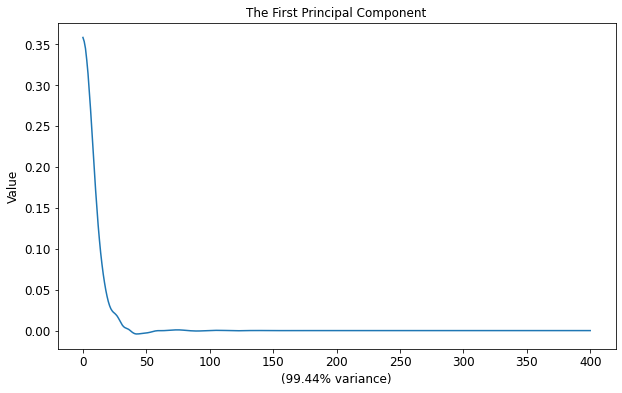

First principal component plotted and saved to 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/PCA_first_principal_component.png


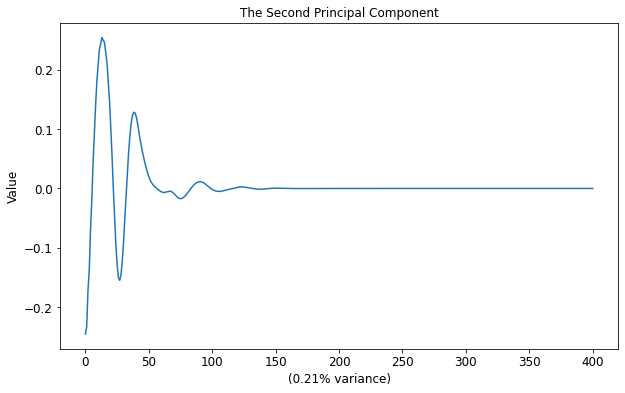

Second principal component plotted and saved to 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/PCA_second_principal_component.png


/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Directory '0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering' already exists, no need to create.
Clustering results saved: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/clustering_results.csv


<Figure size 432x288 with 0 Axes>

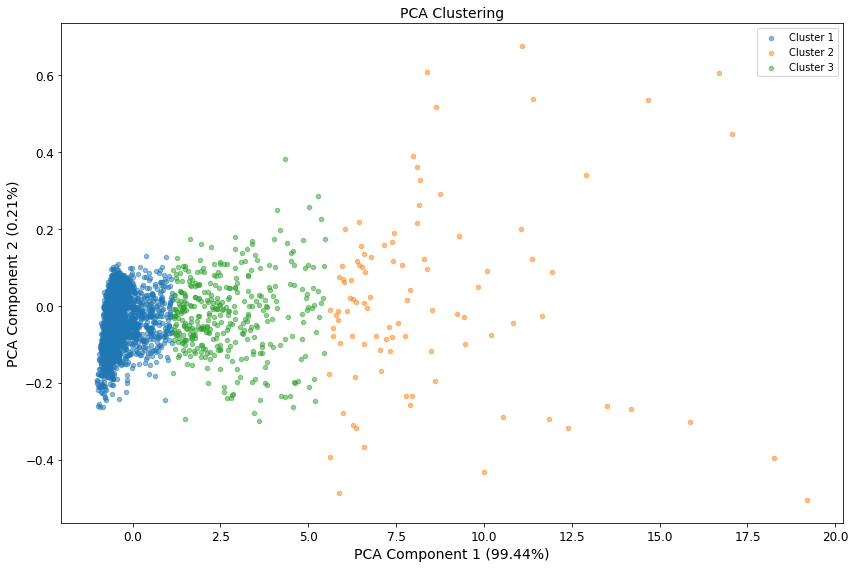

Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/pca_clustering.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/chi_cluster_1.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/chi_cluster_2.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/chi_cluster_3.png
Combined plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_pca_clustering/chi_all_clusters.png
Processing feature: xmu, data_dir: 0926-datasets/xmu, output_dir: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering


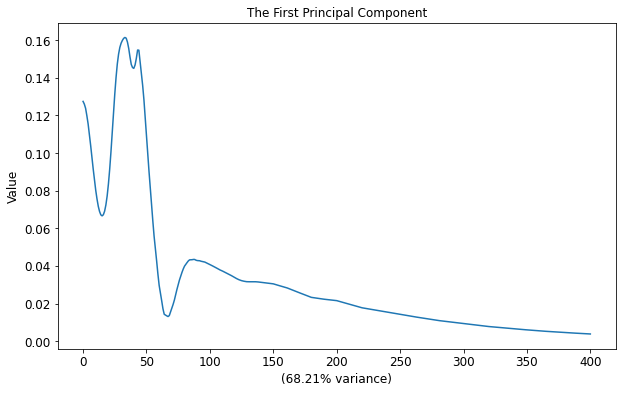

First principal component plotted and saved to 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/PCA_first_principal_component.png


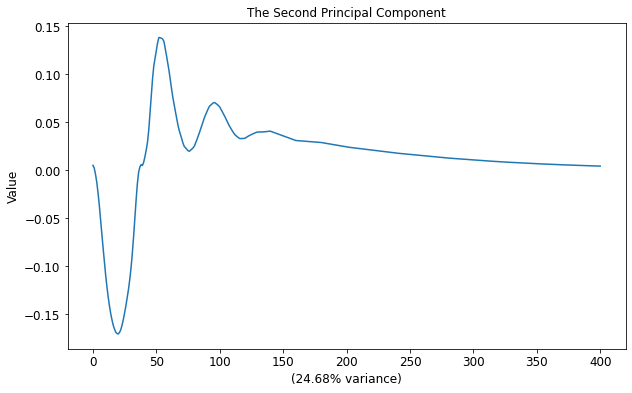

Second principal component plotted and saved to 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/PCA_second_principal_component.png


/home/dell-hd/xraylarch/envs/hanxue2/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Directory '0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering' already exists, no need to create.
Clustering results saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/clustering_results.csv


<Figure size 432x288 with 0 Axes>

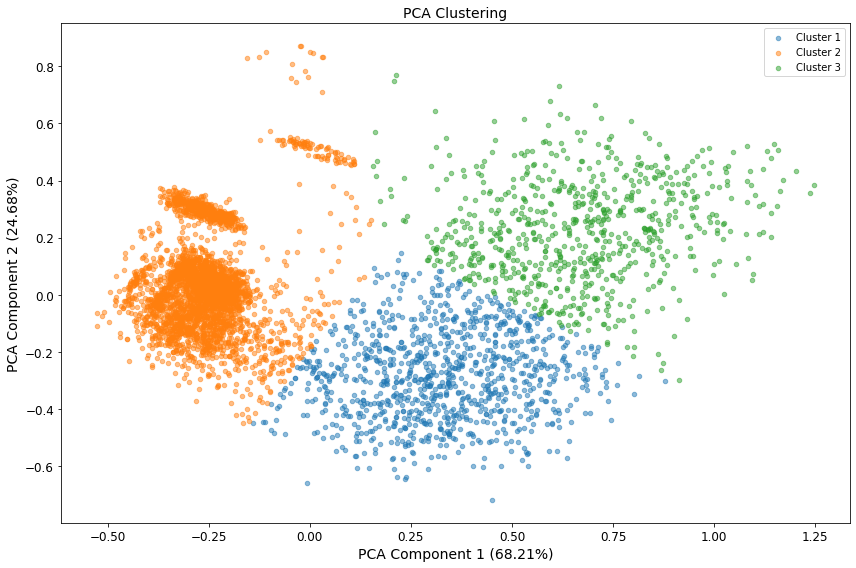

Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/pca_clustering.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/xmu_cluster_1.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/xmu_cluster_2.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/xmu_cluster_3.png
Combined plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_pca_clustering/xmu_all_clusters.png


In [10]:
if read_after_division:
    plot_pca(features, labels, keyword, data_set, file_paths,  statistics_path)
else:
    execute_pca_clustering(features, remove_excluded=remove_excluded)
   

## K-Means

Processing file:0926-datasets/chi
Directory '0926-datasets/Data-Analysis_20250115_1713/chi_clustering' created.


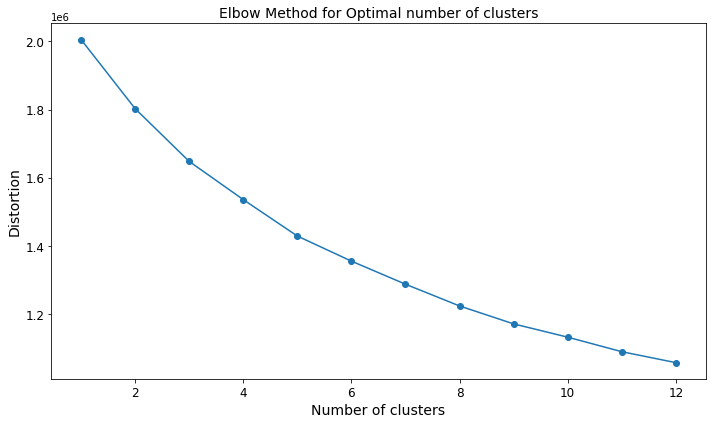

Elbow plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/elbow_plot.png
Please enter the desired number of clusters based on the elbow plot: 4
Number of clusters:4
Clustering results saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/clustering_results.csv
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/chi_cluster_1.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/chi_cluster_2.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/chi_cluster_3.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/chi_cluster_4.png
Combined plot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/chi_all_clusters.png
Clustering completed successfully.
Directory '0926-datasets/Data-Analysis_20250115_1713/chi_clustering' already exists, no need to create.
Boxplot saved: 0926-datasets/Data-Analysis_20250115_1713/chi_clustering/boxplot_cr_MinimumDistanceNN.png
Boxplot saved: 0926-d

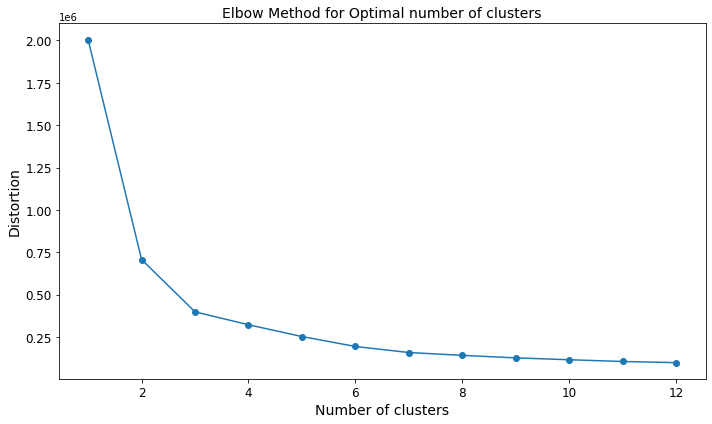

Elbow plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/elbow_plot.png
Please enter the desired number of clusters based on the elbow plot: 4
Number of clusters:4
Clustering results saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/clustering_results.csv
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/xmu_cluster_1.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/xmu_cluster_2.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/xmu_cluster_3.png
Plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/xmu_cluster_4.png
Combined plot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/xmu_all_clusters.png
Clustering completed successfully.
Directory '0926-datasets/Data-Analysis_20250115_1713/xmu_clustering' already exists, no need to create.
Boxplot saved: 0926-datasets/Data-Analysis_20250115_1713/xmu_clustering/boxplot_cr_MinimumDistanceNN.png
Boxplot saved: 0926-d

In [11]:
if read_after_division:
    process_features(features, file_paths, statistics_path, keyword, data_set, max_clusters=12)
else:
    # Define the main program
    main(features, labels)
   